# Veri Seti Hikayesi

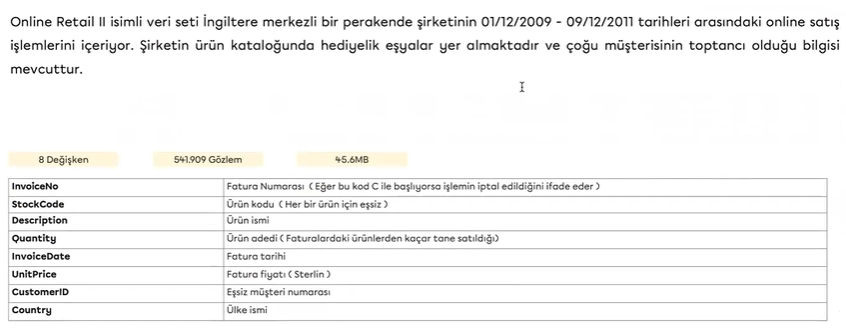


# Görev 
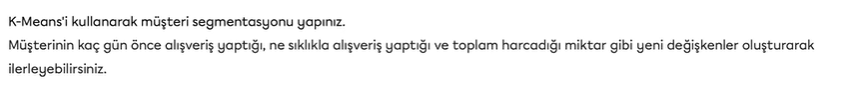

In [1]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np
import warnings

pd.set_option ('display.max_columns', 50)
pd.set_option ('display.max_rows', 50)
pd.set_option ('display.float_format', lambda x: '%.2f' % x)
pd.set_option ('display.width', 1000)
warnings.filterwarnings ("ignore")

df_ = pd.read_excel (r"C:\Users\ceren\Desktop\miuul\machine_learning\online_retail_II.xlsx", sheet_name="Year 2009-2010")

In [3]:
df = df_.copy ()

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [7]:
def check_data(dataframe, head=5):
    print ("####### SHAPE #######")
    print (dataframe.shape)
    print ("####### INFO #######")
    print (dataframe.info ())
    print ("####### DESCRIBE #######")
    print (dataframe.describe ([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print ("####### NA VALUES #######")
    print (dataframe.isnull ().sum ())
    #print ("####### FIRST {} ROWS #######".format (head))
    #print (dataframe.head (head))

def select_country(dataframe, country):
    new_dataframe = dataframe.loc[dataframe["Country"] == country]
    return new_dataframe


def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds (dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any (axis=None):
        return True
    else:
        return False


def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile (q1)
    quartile3 = dataframe[col_name].quantile (q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [6]:
check_data(df)

####### SHAPE #######
(525461, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
####### DESCRIBE #######
       Quantity     Price  Customer ID
count 525461.00 525461.00    417534.00
mean      10.34      4.69     15360.65
std      107.42    146.13      1680.81
min    -9600.00 -53594.36     12346.00
1%        -3.00      0.21   

Describe fonksiyonunun çıktısına baktığımızda:
#### Quantity :

* minimum değer olan -9600 değeri göze çarpıyor.

* mean 10.34 iken medyanı 3 olduğu için sağa çarpık bir dağılım söz konusu.

* %95'de 30 iken %99'da 120, max değer ise 19252 outlier olabilir.

#### Price :

* minimum değer olan -53594 değeri göze çarpıyor.

* %99'da 19.95 iken max değer 25111 olması outlier olması ihtimalini arttırıyor.

Na değerlerine baktığımızda:

* Description      2928

* Customer ID    107927 tane boş değer görülüyor.

Veriyi incelediğimizde Description yerine StockCode'dan ilerlemek bizim için daha faydalı olur. Tanımı aynı olan ürün olabilir fakat farklı özelliklerden dolayı (örneğin paketleme) stok kodu her zaman farklı olacaktır.

In [8]:
df = df[~df["Invoice"].str.contains ("C", na=False)]
df = df[(df['Quantity'] > 0)]

In [9]:
df.dropna (inplace=True)
df.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,Price,Customer ID
count,407695.00,407695.00,407695.00
mean,13.59,3.29,15368.50
std,96.84,34.76,1679.80
min,1.00,0.00,12346.00
1%,1.00,0.29,12435.00
10%,1.00,0.65,13044.00
25%,2.00,1.25,13997.00
50%,5.00,1.95,15321.00
75%,12.00,3.75,16812.00
90%,24.00,6.75,17706.00


In [10]:
df[df["Price"] == 0]["StockCode"].unique ()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [12]:
df[df["StockCode"] == "M"].head() 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
11310,490300,M,Manual,1,2009-12-04 14:19:00,0.85,12970.00,United Kingdom
11311,490300,M,Manual,1,2009-12-04 14:19:00,0.21,12970.00,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.00,17231.00,United Kingdom
17386,490760,M,Manual,1,2009-12-08 09:49:00,10.00,14295.00,United Kingdom
17887,490881,M,Manual,1,2009-12-08 12:58:00,10.00,16210.00,United Kingdom


Manuel bir işlem var iş birimiyle bununla ilgili konuşulmalı ürünün ne olacağının geri bildirimini alamayacağımız için veri setindne çıkaralım. 

In [13]:
df = df[df["StockCode"] != "M"]

In [15]:
invalid_codes = df[df["StockCode"].astype (str).str.contains (r"[a-zA-Z]{3,}")]["StockCode"].unique ().tolist ()
invalid_codes #3ten fazla string barındıran stockcodeları getirdik.

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [16]:
df.loc[df["StockCode"].isin(invalid_codes)].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
322961,520848,POST,POSTAGE,3,2010-08-31 12:52:00,18.00,12623.00,Germany
415699,529127,POST,POSTAGE,1,2010-10-26 14:24:00,15.00,12775.00,Netherlands
115799,500367,POST,POSTAGE,1,2010-03-08 08:09:00,40.00,12369.00,Austria
415485,529084,POST,POSTAGE,6,2010-10-26 13:15:00,18.00,12524.00,Germany
220941,510824,POST,POSTAGE,1,2010-06-03 19:57:00,15.00,12643.00,France
324892,521040,POST,POSTAGE,1,2010-09-02 09:27:00,18.00,12471.00,Germany
393998,527255,POST,POSTAGE,3,2010-10-15 12:35:00,18.00,12437.00,France
234317,512083,POST,POSTAGE,2,2010-06-13 12:32:00,18.00,12623.00,Germany
398583,527479,POST,POSTAGE,1,2010-10-18 11:34:00,18.00,12665.00,Germany
279133,516566,POST,POSTAGE,1,2010-07-21 12:31:00,18.00,12417.00,Belgium


In [17]:
df[df["StockCode"].isin (invalid_codes)].groupby (["StockCode"]).agg ({"Invoice": "nunique",
                                                                       "Quantity": "sum",
                                                                       "Price": "sum",
                                                                       "Customer ID": "nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


Verileri çıkarmadan inceleyim:

Çoğunluğu Post'tan geliyor

In [18]:
df = df[~df["StockCode"].isin (invalid_codes)].reset_index (drop=True)

In [19]:
check_data (df)


####### SHAPE #######
(406450, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406450 entries, 0 to 406449
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406450 non-null  object        
 1   StockCode    406450 non-null  object        
 2   Description  406450 non-null  object        
 3   Quantity     406450 non-null  int64         
 4   InvoiceDate  406450 non-null  datetime64[ns]
 5   Price        406450 non-null  float64       
 6   Customer ID  406450 non-null  float64       
 7   Country      406450 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB
None
####### DESCRIBE #######
       Quantity     Price  Customer ID
count 406450.00 406450.00    406450.00
mean      13.62      3.01     15373.48
std       96.99      4.37      1677.23
min        1.00      0.00     12346.00
1%         1.00      0.29   

* Recency(müşterinin en son alışveriş yaptığı tarih ile günümüz arasındaki fark) 

* Freq(müşterinin işlem sayısı)

* Monetary (müşterinin işlem başına yaptığı harcama)

In [20]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [21]:
df.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])


,Quantity,Price,Customer ID,TotalPrice
count,406450.00,406450.00,406450.00,406450.00
mean,13.62,3.01,15373.48,21.36
std,96.99,4.37,1677.23,69.14
min,1.00,0.00,12346.00,0.00
1%,1.00,0.29,12437.00,0.65
10%,1.00,0.65,13050.00,2.10
25%,2.00,1.25,14006.00,4.95
50%,5.00,1.95,15325.00,11.85
75%,12.00,3.75,16814.00,19.50
90%,24.00,6.75,17706.00,35.40


TotapPrice için %99 ile max arasında fark yüksek görünüyor. 

RFM belirlenirken sabit bir tarih belirlememiz gerekiyor.

In [23]:
max_invoice_date = df["InvoiceDate"].max ()
max_invoice_date

Timestamp('2010-12-09 20:01:00')

In [24]:
today_date = (max_invoice_date + dt.timedelta (days=2))
today_date

Timestamp('2010-12-11 20:01:00')

In [25]:
rfm = df.groupby ("Customer ID").agg ({"InvoiceDate": lambda date: (today_date - date.max ()).days,
                                       "Invoice": "nunique",
                                       "TotalPrice": "sum"})


In [26]:
rfm.head ()


,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [27]:
rfm.columns = ["Recency", "Frequency", "Monetary"]


In [28]:
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]


In [29]:
rfm.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])


,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.43,2025.18
std,96.35,7.95,8829.91
min,2.00,1.00,1.55
1%,2.00,1.00,40.76
10%,9.00,1.00,157.04
25%,19.00,1.00,307.66
50%,53.00,2.00,702.26
75%,136.75,5.00,1703.99
90%,255.00,9.00,3761.56


In [30]:
for col in rfm.columns:
    print (col, check_outlier (rfm, col))

Recency False
Frequency True
Monetary True


In [31]:
for col in rfm.columns:
    replace_with_thresholds (rfm, col)

In [32]:
rfm.describe ()


,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.11,1588.58
std,96.35,4.89,2523.16
min,2.00,1.00,1.55
25%,19.00,1.00,307.66
50%,53.00,2.00,702.26
75%,136.75,5.00,1703.99
max,375.00,31.00,15243.20


* 2. kez törpülenmemeli (baskılanmamallı)

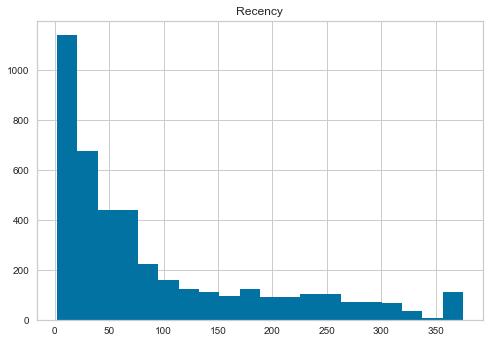

In [33]:
rfm["Recency"].hist (bins=20)
plt.title ("Recency")
plt.show ()

Normal dağılmıyor.

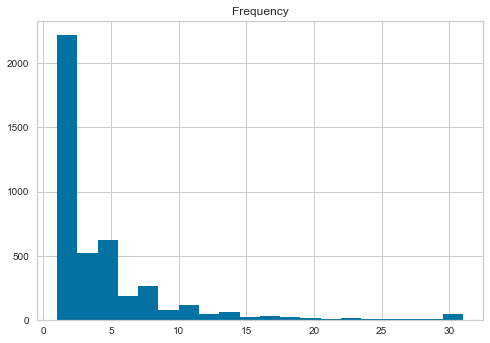

In [34]:
rfm["Frequency"].hist (bins=20)
plt.title ("Frequency")
plt.show ()

Normal dağılmıyor. Normale yakınlaştıralım: 

In [35]:
# LOG TRANSFORMATION
for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p (rfm[col])
rfm.head () 


,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.00,166.00,2.00,169.36,5.12,1.10
12347.00,4.00,2.00,1323.32,1.61,1.10
12348.00,75.00,1.00,221.16,4.33,0.69
12349.00,44.00,2.00,2221.14,3.81,1.10
12351.00,12.00,1.00,300.93,2.56,0.69


In [36]:
# SCALER
sc = StandardScaler ()
sc.fit (rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform (rfm[["LOG_Recency", "LOG_Frequency"]]) 

array dönüyor df aktaralım.

In [37]:
scaled_df = pd.DataFrame (index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
scaled_df

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00
...,...,...
18283.00,-0.73,0.87
18284.00,0.27,-1.00
18285.00,1.45,-1.00


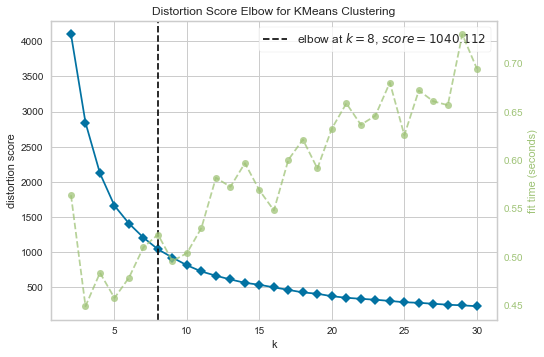

In [38]:
# Determining Optimal Numbers of Cluster
kmeans = KMeans ()
elbow = KElbowVisualizer (kmeans, k=30)
elbow.fit (scaled_df)
elbow.show ();

In [39]:
k_ = elbow.elbow_value_
k_

8

In [40]:
# K-Means
k_means = KMeans (n_clusters=k_, random_state=99).fit (scaled_df)
segments = k_means.labels_

rfm["KMeans_Segments"] = segments
rfm.head ()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segments
Customer ID,,,,,,
12346.00,166.00,2.00,169.36,5.12,1.10,1
12347.00,4.00,2.00,1323.32,1.61,1.10,0
12348.00,75.00,1.00,221.16,4.33,0.69,2
12349.00,44.00,2.00,2221.14,3.81,1.10,2
12351.00,12.00,1.00,300.93,2.56,0.69,6


In [41]:
rfm.groupby ("KMeans_Segments").agg ({"Recency": ["mean", "median", "count"],
                                      "Frequency": ["mean", "median", "count"],
                                      "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                   mean median count      mean median count     mean  median count
KMeans_Segments                                                                   
0                  6.39   5.00   352      5.23   5.00   352  1896.92 1382.81   352
1                241.97 234.00   939      1.24   1.00   939   403.23  266.50   939
2                 69.27  66.00   790      1.43   1.00   790   533.50  378.46   790
3                 32.65  25.00   384     10.40   9.00   384  4145.36 3148.77   384
4                  6.02   5.00   214     19.23  17.00   214  7843.35 6008.61   214
5                118.37  96.00   578      4.17   4.00   578  1667.55 1234.72   578
6                 20.11  20.00   474      1.47   1.00   474   506.44  350.01   474
7                 29.66  29.00   555      4.08   4.00   555  1561.51 1189.38   555

* 2-6. segmentte çok fark yok gibi görünüyor fakat Recency incelediğimizde 66-20, müşteriye farklı kampanyalar uygulanabilir.   

* 5-7. segmentte çok fark yok gibi görünüyor fakat Recency incelediğimizde 96-29, müşteriye farklı kampanyalar uygulanabilir.   



Görselleştirelim:

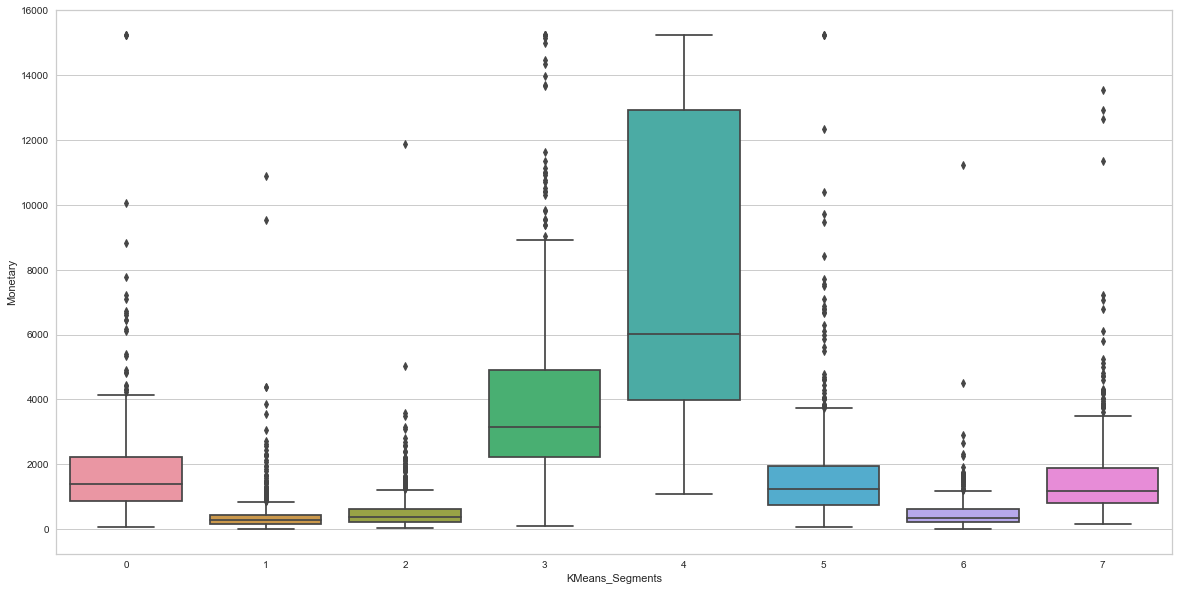

In [42]:
plt.figure (figsize=(20, 10))
sns.boxplot (x="KMeans_Segments", y="Monetary", data=rfm)
plt.show ();

İşimizi garantiye alıp hiyerarşi kümeleme de yapalım:

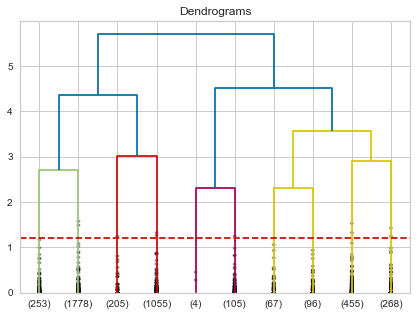

In [43]:
# Hierarchical Clustering

hc_complete = linkage (scaled_df, 'complete')

plt.figure (figsize=(7, 5))
plt.title ("Dendrograms")
dend = dendrogram (hc_complete,
                   truncate_mode="lastp",
                   p=10, #dal
                   show_contracted=True,
                   leaf_font_size=10)
plt.axhline (y=1.2, color='r', linestyle='--')
plt.show ()

Görsele bakarak 6'ya böleceğimize karar verdik.

In [44]:
hc = AgglomerativeClustering (n_clusters=6)
segments = hc.fit_predict (scaled_df)
rfm["Hierarchi_Segments"] = segments

In [45]:
rfm.groupby ("Hierarchi_Segments").agg ({"Recency": ["mean", "median", "count"],
                                         "Frequency": ["mean", "median", "count"],
                                         "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                      mean median count      mean median count     mean  median count
Hierarchi_Segments                                                                   
0                    22.54  17.00   915      8.22   7.00   915  3183.45 2342.57   915
1                    71.59  60.00  1091      3.42   3.00  1091  1354.29  940.86  1091
2                   227.53 220.00  1131      1.43   1.00  1131   474.46  301.65  1131
3                    13.24  13.00   462      2.05   2.00   462   654.60  498.72   462
4                    55.18  53.50   534      1.00   1.00   534   413.07  281.32   534
5                     5.11   5.00   153     21.38  19.00   153  8880.06 7637.56   153

* 2-4. birbirine yakın harcama miktarları aynı gözüküyor fakat Recency 220-53 büyük bir fark var. Örnek olarak 2. segmenti daha çok cezbedecek kampanya verilmeli.

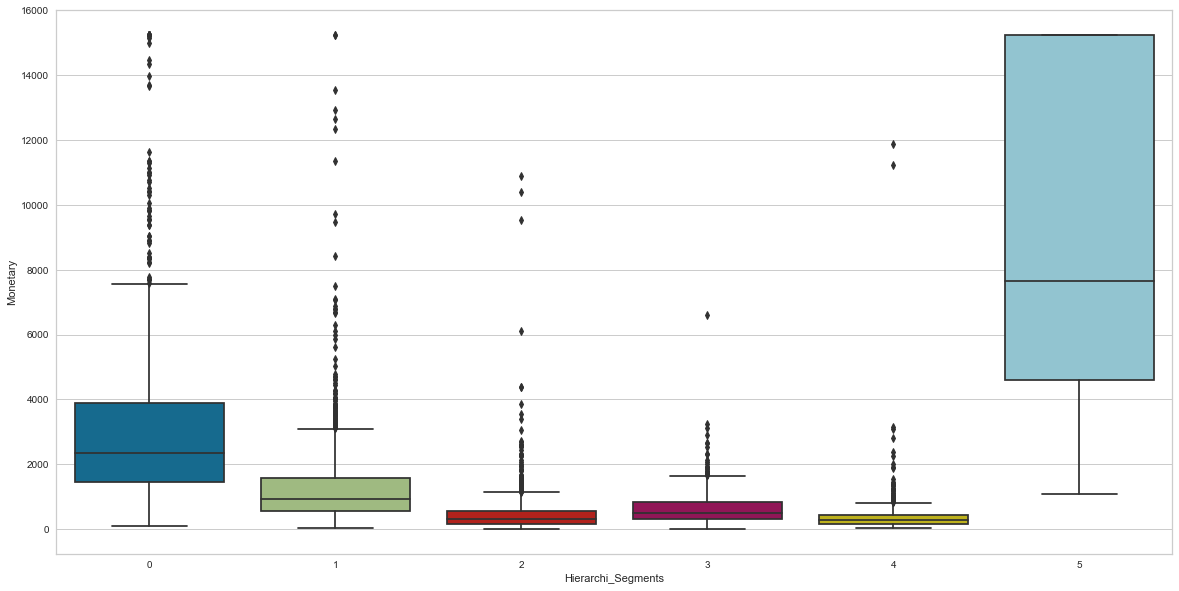

In [46]:
plt.figure (figsize=(20, 10))
sns.boxplot (x="Hierarchi_Segments", y="Monetary", data=rfm)
plt.show ();